In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram

In [3]:
# Функция для построения дендограммы
def plot_dendrogram(model, **kwargs):
    # Создание матрицы связей для визуализации
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Построение дендограммы
    dendrogram(linkage_matrix, **kwargs)

In [4]:
# Визуализация кластеров
def plot_clusters(data, labels, title, n_clusters):
    plt.figure(figsize=(10, 7))
    cmap = ListedColormap(['gray'] + plt.get_cmap('tab10').colors)
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{title} Clustering (Clusters: {n_clusters})')
    plt.colorbar()
    plt.show()

In [5]:
# Визуализация силуэтного анализа
def plot_silhouette_analysis(sil_avg, sample_values, labels, method_name):
    plt.figure(figsize=(10, 6))
    y_lower = 10
    for i in range(len(np.unique(labels))):
        cluster_values = sample_values[labels == i]
        cluster_values.sort()
        size_cluster_i = cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.tab10(float(i) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.title(f"Silhouette Analysis ({method_name})")
    plt.xlabel("Silhouette Coefficient")
    plt.axvline(x=sil_avg, color="red", linestyle="--", label="Avg. Silhouette")
    plt.legend()
    plt.show()

In [6]:
# Загрузка MNIST
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X_train, _, y_train, _ = train_test_split(X, y, train_size=5000, test_size=None)

# PCA для снижения размерности
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

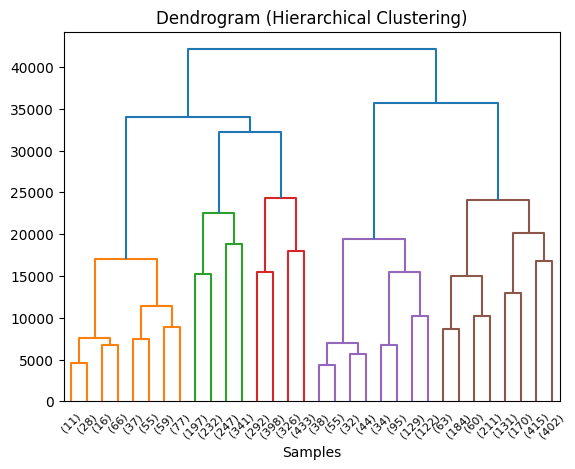

In [7]:
# AgglomerativeClustering
agglomerative_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_train)
plt.title("Dendrogram (Hierarchical Clustering)")
plot_dendrogram(agglomerative_model, truncate_mode="level", p=4)
plt.xlabel("Samples")
plt.show()

In [8]:
def plot_clusters(data, labels, title, n_clusters):
    plt.figure(figsize=(10, 7))
    cmap = ListedColormap(['gray'] + list(plt.get_cmap('tab10').colors))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{title} Clustering (Clusters: {n_clusters})')
    plt.colorbar()
    plt.show()

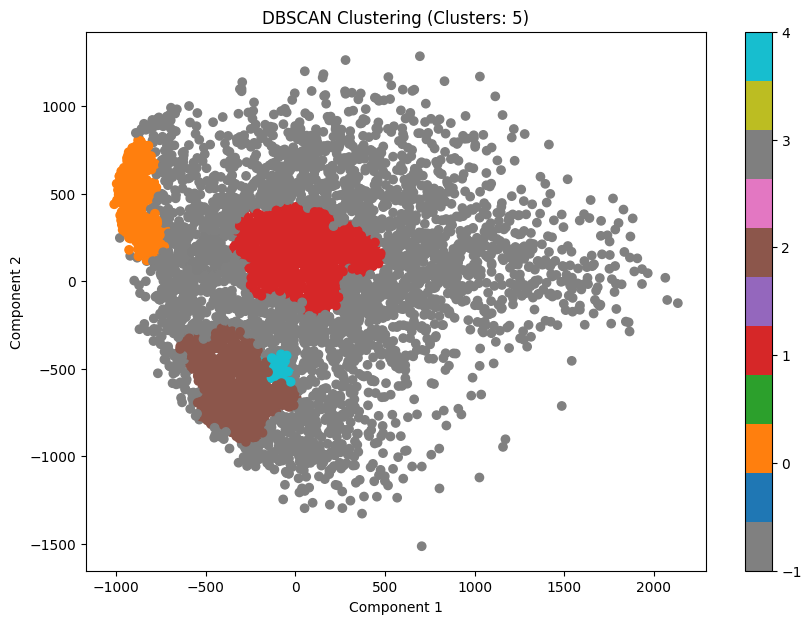

DBSCAN ARI: 0.060
DBSCAN Silhouette Score: -0.127


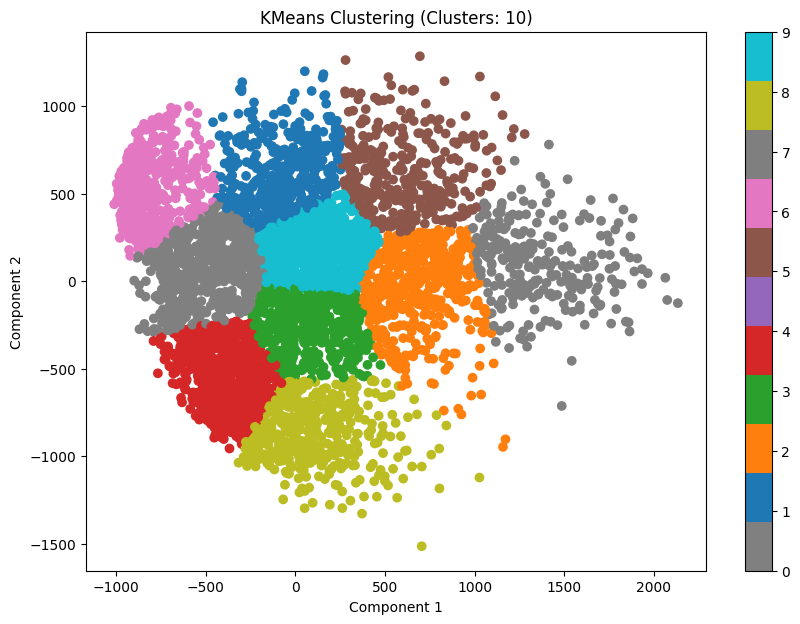

KMeans ARI: 0.227
KMeans Silhouette Score: 0.354


In [9]:
# DBSCAN
dbscan_model = DBSCAN(eps=70, min_samples=40).fit(X_pca)
db_labels = dbscan_model.labels_
db_n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

plot_clusters(X_pca, db_labels, "DBSCAN", db_n_clusters)

db_ari = adjusted_rand_score(y_train.astype(int), db_labels)
db_silhouette = silhouette_score(X_pca, db_labels)
print(f"DBSCAN ARI: {db_ari:.3f}")
print(f"DBSCAN Silhouette Score: {db_silhouette:.3f}")

# KMeans
kmeans_model = KMeans(n_clusters=10, random_state=42).fit(X_pca)
kmeans_labels = kmeans_model.labels_

plot_clusters(X_pca, kmeans_labels, "KMeans", 10)

km_ari = adjusted_rand_score(y_train.astype(int), kmeans_labels)
km_silhouette = silhouette_score(X_pca, kmeans_labels)
print(f"KMeans ARI: {km_ari:.3f}")
print(f"KMeans Silhouette Score: {km_silhouette:.3f}")

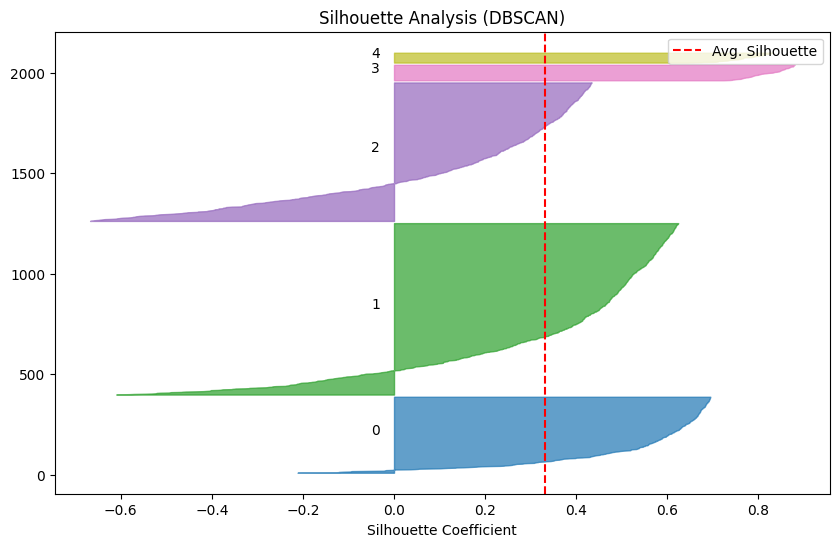

In [10]:
# Визуализация силуэтного анализа для DBSCAN
if len(set(db_labels)) > 1:  # Проверяем, что есть больше одного кластера
    sample_silhouette_values = silhouette_samples(X_pca, db_labels)
    valid_labels = db_labels[db_labels != -1]  # Убираем шумовые точки
    valid_samples = sample_silhouette_values[db_labels != -1]  # Соответствующие значения силуэтов
    silhouette_avg = silhouette_score(X_pca[db_labels != -1], valid_labels)

    plot_silhouette_analysis(
        sil_avg=silhouette_avg,
        sample_values=valid_samples,
        labels=valid_labels,
        method_name="DBSCAN"
    )
else:
    print("DBSCAN не нашел достаточно кластеров для выполнения силуэтного анализа.")

Построенная дендограмма иллюстрирует иерархию объединения данных, но не позволяет выделить корректное количество кластеров — ожидалось 10, однако выделяется меньше. Метод продемонстрировал ограниченную применимость к данному датасету из-за его высокой размерности и сложности.

Метод DBSCAN выявил несколько кластеров, но также отметил значительное количество шумовых точек. Значение ARI (0.060) указывает на слабую корреляцию с истинной разметкой, а отрицательный силуэтный коэффициент (-0.127) свидетельствует о том, что кластеры пересекаются или плохо разделены. Этот метод показал низкую эффективность из-за трудностей применения плотностного подхода к данным с высокой размерностью и неоднородностью.

Сравнивая методы, KMeans продемонстрировал лучшие результаты среди всех рассмотренных алгоритмов. Значение ARI (0.227) и положительный силуэтный коэффициент (0.354) говорят о частичном соответствии кластеризации истинным меткам и более четком разделении кластеров. Тем не менее, качество кластеризации все еще далек от идеала из-за шумности и сложности исходного набора данных.

Таким образом, можно сделать общий вывод: методы кластеризации сталкиваются с серьезными трудностями при работе с датасетом MNIST из-за его высокой размерности, наличия шума и сильной схожести между классами. Метод KMeans показывает результаты лучше, но они все еще недостаточны для точной кластеризации.

Для улучшения качества кластеризации нужно провести предварительное отбеливание данных и использовать более сложные алгоритмы.